In [18]:
import numpy as np
import pandas as pd     
import matplotlib.pyplot as plt 

from scipy.special import factorial
import fileinput
import os

%config InlineBackend.figure_format='svg'
%matplotlib inline

## Information:
This notebook is about generating random maps with the layer coefficients provided by the aLIGO measured map 'ETM05_S1_finesse.txt'.

The layer coefficients calculated from 'ETM05_S1_finesse' are:
[0, 0, 0.20190713375335292, 0.1458974321372058, 0.13728131907327343, 0.0647602622253127,
 0.0639643843456696, 0.06163558192765335, 0.11786865519746435, 0.10733282124903537...], which are calculated in notebook 'Layer coefficients calculation for aLIGO measured maps.ipynb'

In [38]:
# Create a list of Zernike basis to form the random maps
def Zernikebasis(shape, radius, step_size, max_zern=25):
    center = (shape-1)/2
    rrange = radius/step_size
    zernikes=[]
    def theta(x,y):
        phi = np.arctan2(y, x)
        return phi
    
    def radial(x,y,n,m):
        if m<0:
            m=-m
        sum=0
        for k in range(int((n-m)/2)+1):   
            r=(-1)**k*factorial(n-k)/factorial(k)/factorial((n+m)/2-k)/factorial((n-m)/2-k)*((x**2+y**2)/(rrange**2))**(n/2-k)
            sum+=r
        return sum

    def angular(x,y,n,m): 
        a=theta(x,y)
        if m>=0:
            angular=np.cos(m*a)
        else:
            angular=-np.sin(m*a)
        return angular
    
    for n in range(max_zern):
        for m in range(-n,n+1,2):
            stepRange = np.arange(shape)-center
            x,y=np.meshgrid(stepRange,stepRange,sparse=True)
            zfunc=radial(x,y,n,m)*angular(x,y,n,m)
            for i in range(shape):
                for j in range(shape): 
                    if (i-center)**2+(j-center)**2>= rrange**2:
                        zfunc[i][j]=0
            zmap=zfunc/np.abs(zfunc).max()
            zernikes.append(zmap)
    return zernikes

# Create a conversion between mode index pair {n}{m} to {i}
i=0
dic={} 
for n in range(25):
    for m in range(-n,n+1,2):
        dic[f'{n}{m}']=i
        i=i+1
    
# the number of zernikes up to a given order
def num_zernikes(order):
    i = 0
    for n in range(order):
        for m in range(-n,n+1,2):
            i=i+1
    return i

# Calculate the random coefficients with a given layer coefficients as coeff
def randomCoeff(coeff, max_zern=25):
    num = num_zernikes(max_zern)
    randomCoeff=np.random.rand(num)-0.5 # First create random numbers from U(-0.5, 0.5)
    norm=[]
    for n in range(max_zern):
        squ_sum=0
        for m in range(-n,n+1,2):
            index=dic[f'{n}{m}']
            if n==2 and m==0:
                continue
            else:
                squ_sum+=randomCoeff[index]**2
        norm.append(np.sqrt(squ_sum)) # Calculate the 'norm' at each layer

    for n in range(max_zern):
        for m in range(-n,n+1,2):
            index=dic[f'{n}{m}']
            if n==2 and m==0:
                randomCoeff[index]=0
            else:
                randomCoeff[index]=coeff[n]*randomCoeff[index]/norm[n] # The random Zernike coefficients are normalized
                # by the norm and the required layer coefficients 'coeff'. In this way the new random Zernike coefficients
                # are both random and have the same layer coefficient as 'coeff'
    return randomCoeff

# Create a list of Zernike basis, this takes a long time to run, and takes up a lot of ram
basis=Zernikebasis(shape=1131, radius=0.15, step_size=0.0002669951063580811)

def randommaps(coeff, max_zern=25):
    coeffs=randomCoeff(coeff=coeff, max_zern=max_zern)
    random_map=0
    num = num_zernikes(max_zern)
    for i in range(num):
        random_map+=basis[i]*coeffs[i] 
        # A linear combination of the zernike basis with the random zernike coefficients
            # calculated in function 'randomCoeff'
    return coeffs, random_map

In [29]:
aLIGO=pd.read_csv('./ETM05_S1_finesse.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values

overlap=[]
for n in range(8):
    for m in range(-n,n+1,2):
        znm = basis[dic[f'{n}{m}']]
        coeff=(aLIGO*znm).sum()/((znm**2).sum())
        overlap.append(coeff)
        
xticks=['$Z_{0}^{0}$','$Z_{1}^{-1}$','$Z_{1}^{1}$','$Z_{2}^{-2}$','$Z_{2}^{0}$','$Z_{2}^{2}$','$Z_{3}^{-3}$',
        '$Z_{3}^{-1}$','$Z_{3}^{1}$','$Z_{3}^{3}$','$Z_{4}^{-4}$','$Z_{4}^{-2}$','$Z_{4}^{0}$','$Z_{4}^{2}$',
        '$Z_{4}^{4}$','$Z_{5}^{-5}$','$Z_{5}^{-3}$','$Z_{5}^{-1}$','$Z_{5}^{1}$','$Z_{5}^{3}$','$Z_{5}^{5}$',
        '$Z_{6}^{-6}$','$Z_{6}^{-4}$','$Z_{6}^{-2}$','$Z_{6}^{0}$','$Z_{6}^{2}$','$Z_{6}^{4}$','$Z_{6}^{6}$',
       '$Z_{7}^{-7}$','$Z_{7}^{-5}$','$Z_{7}^{-3}$','$Z_{7}^{-1}$','$Z_{7}^{1}$','$Z_{7}^{3}$','$Z_{7}^{5}$',
       '$Z_{7}^{7}$']

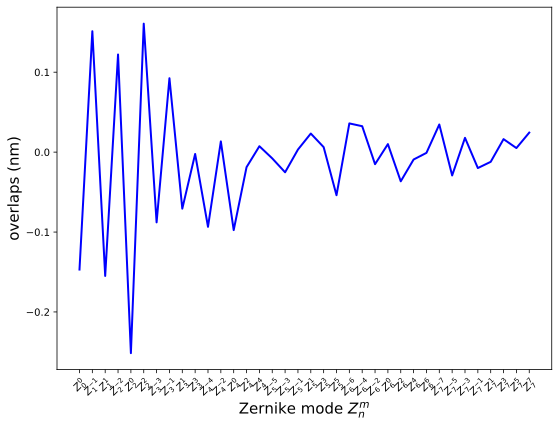

In [30]:
fig,ax =plt.subplots(figsize=(8,6))
fig.subplots_adjust(bottom=0.12, top=0.96, left=0.1, right=0.96)
ax.plot(overlap, 'b', linewidth=2)

ax.set_ylabel("overlaps (nm)", fontsize=15)
ax.set_xlabel("Zernike mode $Z_{n}^{m}$",fontsize=15)

ax.set_xticks(range(36))
ax.set_xticklabels(xticks,rotation=45)

# plt.savefig('decomposition.pdf')
plt.show()

In [15]:
##### add the file header to generate a map
def insert(originalfile,string):
    with open(originalfile,'r') as f:
        with open('temp.txt','w') as f2: 
            f2.write(string)
            f2.write(f.read())
    os.rename('temp.txt',originalfile)

def mapfileheader(filename, mapdata):
    with open('./ETM05_S1_finesse.txt') as myfile: # take the header from an existing map
        head = [next(myfile) for x in range(9)]
    header="".join(head)

    np.savetxt(filename, mapdata, delimiter=' ',fmt='%1.4f') # Save the mapdate along with the map header
    insert(filename,f'''{header}''')

In [41]:
# Code testing: generate a random map called 'testing.txt' with layer coefficients [0,0,1,2,3,4,5,6,7,8]
# 'testing.txt' will be decomposed in file 'Layer coefficients calculation for aLIGO measured maps'
# The calculated layer coefficients should be close to what set here [0,0,1,2,3,4,5,6,7,8]
_, testing = randommaps(coeff=[0,0,1,2,3,4,5,6,7,8], max_zern=10)
mapfileheader('testing.txt', testing)

In [42]:
# This is from the calculation in 'Layer coefficients calculation for aLIGO measured maps.ipynb'
random_Coeffs = [0, 0, 0.20190713375335295, 0.14589743213720582, 0.13728131907327343, 0.06476026222531271,
 0.06396438434566958, 0.0616355819276533, 0.11786865519746435, 0.10733282124903534, 0.07524138634759972,
 0.046375544797053296, 0.05357200662514628, 0.0878930592250278, 0.07583595265248438, 0.07497225394676169,
 0.07595435402124659, 0.06254947966202422, 0.08196084165372426, 0.08585295172293457, 0.08870503602805534, 
 0.09579683509187605, 0.08575422531961867, 0.07738351927467897, 0.07309294568711436]

for i in range(1): # Generate 1 random map from the map ETM05_S1_finesse
    _, mapdata = randommaps(coeff=random_Coeffs) # generate the random map data
    mapfileheader(f'randommap{i}.txt', mapdata) # adding the map file headers and filenames

In [36]:
def randommaps_up_to_order(max_index, coeffs):
    random_map=0
    for i in range(max_index):
        random_map+=basis[i]*coeffs[i]
    return random_map

# generate one random map based on the layer coefficients to test its convergence 

for i in range(1):
    coeffs, mapdata = randommaps(coeff=random_Coeffs) 
    mapfileheader(f'./order{order}randommap{i}.txt', mapdata)

    for order in range(3,25):
        mapdata = randommaps_up_to_order(num_zernikes(order), coeffs=coeffs) 
        mapfileheader(f'./order{order}randommap{i}.txt', mapdata)